In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
! ls

gdrive	sample_data


In [3]:
%cd gdrive/My Drive/Deep_XT

/content/gdrive/My Drive/Deep_XT


Cloning into 'Deep_XT'...
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 14 (delta 1), reused 4 (delta 1), pack-reused 0
Unpacking objects: 100% (14/14), done.


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from glob import glob
import zipfile as zf
from skimage.io import imread
import h5py

In [0]:
%matplotlib inline

In [6]:
from keras.utils.io_utils import HDF5Matrix
base_h5_dir = 'Deep_XT'
base_img_dir = 'Deep_XT'

Using TensorFlow backend.


In [7]:
h5_path = os.path.join(base_h5_dir, 'deeplesion.h5')
with h5py.File(h5_path, 'r') as h:
    print(list(h.keys()))
    for k in ['image', 'mask']:
        print(k, h[k].shape, h[k].dtype)
    base_shape = h['image'].shape

['file_name', 'image', 'mask']
image (1350, 512, 512, 1) float64
mask (1350, 512, 512, 1) bool


In [8]:
ct_window_func = lambda x: np.clip((x+175.0)/275, -1, 1)
get_xyf = lambda s, e: (HDF5Matrix(h5_path, 'image', start=s, end=e, normalizer=ct_window_func), 
                       HDF5Matrix(h5_path, 'mask', start=s, end=e),
                       HDF5Matrix(h5_path, 'file_name', start=s, end=e)
                      )
train_split = 0.7
cut_val = int(base_shape[0]*train_split)
train_x, train_y, train_paths = get_xyf(0, cut_val)
test_x, test_y, test_paths = get_xyf(cut_val, None)
print(train_x.shape, test_x.shape)

(944, 512, 512, 1) (406, 512, 512, 1)


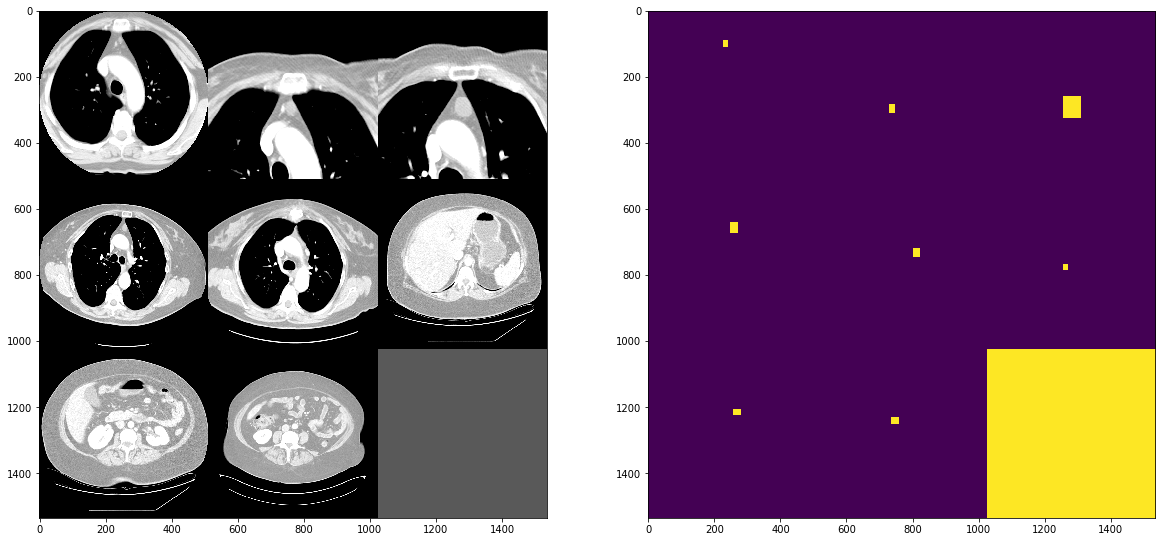

In [9]:
from skimage.util import montage
t_x, t_y = train_x[:8], train_y[:8]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
ax1.imshow(montage(t_x[:, :, :, 0]), cmap = 'gray')
ax2.imshow(montage(t_y[:, :, :, 0]))

In [0]:
class DownsampledHDF5Matrix(HDF5Matrix):
    def __init__(self, datapath, dataset, downscale_factor, start=0, end=None, normalizer=None):
        ds_func = lambda x: x[:, ::downscale_factor, ::downscale_factor, :]
        ds_norm = ds_func if normalizer is None else lambda x: ds_func(normalizer(x))
        self.downscale_factor = downscale_factor
        super(DownsampledHDF5Matrix, self).__init__(datapath, dataset, start=start, end=end, normalizer=ds_norm)
        t_val = self[0:1]
        self._base_shape = t_val.shape[1:]
        self._base_dtype = t_val.dtype
    
    @property
    def shape(self):
        """Gets a numpy-style shape tuple giving the dataset dimensions.
        # Returns
            A numpy-style shape tuple. (self.data.shape[1]//self.downscale_factor, self.data.shape[2]//self.downscale_factor, self.data.shape[3])
        """
        return (self.end - self.start,) + self._base_shape
    
    @property
    def dtype(self):
        """Gets the datatype of the dataset.
        # Returns
            A numpy dtype string.
        """
        return self._base_dtype

(406, 512, 512, 1) (406, 128, 128, 1)


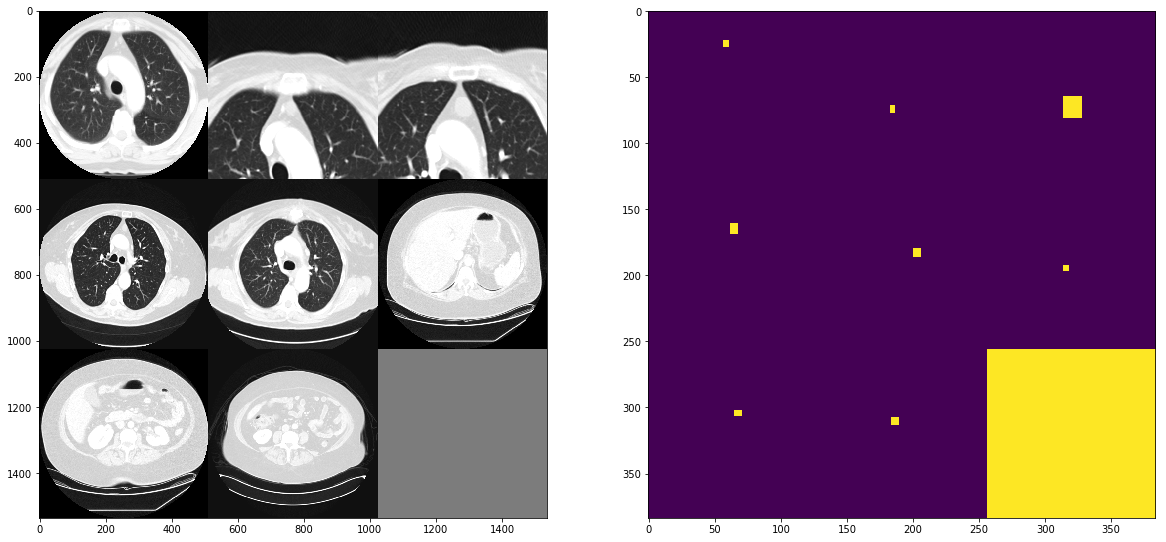

In [11]:
ct_window_func = lambda x: np.clip((x+500.0)/600, -1, 1)
get_xyf = lambda s, e: (HDF5Matrix(h5_path, 'image', start=s, end=e, normalizer=ct_window_func), 
                       DownsampledHDF5Matrix(h5_path, 'mask', downscale_factor=4, start=s, end=e),
                       [x.decode() for x in HDF5Matrix(h5_path, 'file_name', start=s, end=e)[:]]
                      )
train_split = 0.7
cut_val = int(base_shape[0]*train_split)
train_x, train_y, train_paths = get_xyf(0, cut_val)
test_x, test_y, test_paths = get_xyf(cut_val, None)
print(test_x.shape, test_y.shape)
t_x, t_y = train_x[:8], train_y[:8]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
ax1.imshow(montage(t_x[:, :, :, 0]), cmap = 'gray')
ax2.imshow(montage(t_y[:, :, :, 0]))

In [12]:
df = pd.read_csv(os.path.join(base_img_dir, 'DL_info.csv'))
df = df[df['File_name'].isin(train_paths+test_paths)]
df['training'] = df['File_name'].isin(train_paths)
df.sample(3)

,File_name,Patient_index,Study_index,Series_ID,Key_slice_index,Measurement_coordinates,Bounding_boxes,Lesion_diameters_Pixel_,Normalized_lesion_location,Coarse_lesion_type,Possibly_noisy,Slice_range,Spacing_mm_px_,Image_size,DICOM_windows,Patient_gender,Patient_age,Train_Val_Test,training
504,000072_03_01_511.png,72,3,1,511,"348.32, 281.787, 359.54, 268.795, 358.95, 279....","343.32, 263.795, 364.54, 286.787","17.1662, 13.6662","0.75048, 0.552423, 0.793321",-1,0,"481, 541","0.820312, 0.820312, 1","512, 512","-1500, 500",M,14.0,1,True
13132,001305_01_01_056.png,1305,1,1,56,"162.435, 320.696, 161.739, 316.522, 160, 319.3...","155, 311.522, 168.13, 325.696","4.23149, 3.13044","0.305981, 0.560149, 0.378791",5,0,"26, 86","0.781, 0.781, 1","512, 512","-1500, 500",M,62.0,2,False
12600,001221_03_01_059.png,1221,3,1,59,"242.068, 269.497, 266.449, 250.775, 256, 265.5...","237.068, 245.775, 271.449, 274.497","30.7394, 15.7037","0.486382, 0.595974, 0.630744",-1,0,"32, 84","0.976562, 0.976562, 5","512, 512","-175, 275",F,31.0,1,True


In [0]:
from keras.layers import Input, Activation, Conv2D, MaxPool2D, UpSampling2D, Dropout, concatenate, BatchNormalization, Cropping2D, ZeroPadding2D, SpatialDropout2D
from keras.layers import Conv2DTranspose, Dropout, GaussianNoise
from keras.models import Model
from keras import backend as K

In [14]:
def up_scale(in_layer):
    filt_count = in_layer._keras_shape[-1]
    return Conv2DTranspose(filt_count//2+2, kernel_size = (2,2), strides = (2,2), padding = 'same')(in_layer)
def up_scale_fancy(in_layer):
    return UpSampling2D(size=(2,2))(in_layer)

input_layer = Input(shape=train_x.shape[1:])
sp_layer = GaussianNoise(0.1)(input_layer)
bn_layer = BatchNormalization()(sp_layer)
c1 = Conv2D(filters=8, kernel_size=(5,5), activation='relu', padding='same')(bn_layer)
l = MaxPool2D(strides=(2,2))(c1)
c2 = Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(l)
l = MaxPool2D(strides=(2,2))(c2)
c3 = Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(l)

l = MaxPool2D(strides=(2,2))(c3)
c4 = Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(l)

l = SpatialDropout2D(0.25)(c4)
dil_layers = [l]
for i in [2, 4, 6, 8, 12, 18, 24]:
    dil_layers += [Conv2D(16,
                          kernel_size = (3, 3), 
                          dilation_rate = (i, i), 
                          padding = 'same',
                         activation = 'relu')(l)]
l = concatenate(dil_layers)

l = SpatialDropout2D(0.2)(concatenate([up_scale(l), c3], axis=-1))
l = Conv2D(filters=128, kernel_size=(2,2), activation='linear', padding='same')(l)

l = BatchNormalization()(l)
l = Activation('relu')(l)
l = Conv2D(filters=96, kernel_size=(2,2), activation='relu', padding='same')(l)
l = Conv2D(filters=32, kernel_size=(2,2), activation='relu', padding='same')(l)
l = Conv2D(filters=16, kernel_size=(2,2), activation='linear', padding='same')(l)
l = Cropping2D((4,4))(l)
l = BatchNormalization()(l)
l = Activation('relu')(l)

l = Conv2D(filters=1, kernel_size=(1,1), activation='sigmoid')(l)
output_layer = ZeroPadding2D((4,4))(l)

seg_model = Model(input_layer, output_layer)
seg_model.summary()








Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
gaussian_noise_1 (GaussianNoise (None, 512, 512, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 512, 512, 1)  4           gaussian_noise_1[0][0]           
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 8)  208         batc

In [15]:
import keras.backend as K
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)
def dice_p_bce(in_gt, in_pred):
    return 0.0*binary_crossentropy(in_gt, in_pred) - dice_coef(in_gt, in_pred)
def true_positive_rate(y_true, y_pred):
    return K.sum(K.flatten(y_true)*K.flatten(K.round(y_pred)))/K.sum(y_true)
seg_model.compile(optimizer=Adam(1e-4, decay=1e-6), loss=dice_p_bce, metrics=[dice_coef, 'binary_accuracy', true_positive_rate])


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [16]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('seg_model')

checkpoint = ModelCheckpoint(weight_path, monitor='val_dice_coef', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_dice_coef', factor=0.5, 
                                   patience=3, 
                                   verbose=1, mode='max', epsilon=0.0001, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor="val_dice_coef", 
                      mode="max", 
                      patience=15) 
callbacks_list = [checkpoint, early, reduceLROnPlat]

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1335: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [0]:
from keras.preprocessing.image import ImageDataGenerator
dg_args = dict(featurewise_center = False, 
                  samplewise_center = False,
                  rotation_range = 7.5, 
                  width_shift_range = 0.02, 
                  height_shift_range = 0.02, 
                  shear_range = 0.01,
                  zoom_range = [0.9, 1.25],  
                  brightness_range = [0.9, 1.1],
                  horizontal_flip = False, 
                  vertical_flip = False,
                  fill_mode = 'nearest',
                   data_format = 'channels_last')

image_gen = ImageDataGenerator(**dg_args)
dg_args.pop('brightness_range')
label_gen = ImageDataGenerator(**dg_args)
def train_gen(batch_size = 16, seed = None):
    np.random.seed(seed if seed is not None else np.random.choice(range(9999)))
    while True:
        seed = np.random.choice(range(9999))
        # keep the seeds syncronized otherwise the augmentation to the images is different from the masks
        batch_count = train_x.shape[0]//batch_size
        batch_id = np.random.permutation(range(0, train_x.shape[0]-batch_size, batch_size))
        for c_idx in batch_id:
            g_x = image_gen.flow(train_x[c_idx:(c_idx+batch_size)], batch_size = batch_size, seed = seed, shuffle=True)
            g_y = label_gen.flow(train_y[c_idx:(c_idx+batch_size)], batch_size = batch_size, seed = seed, shuffle=True)
            yield next(g_x)/255.0, next(g_y)

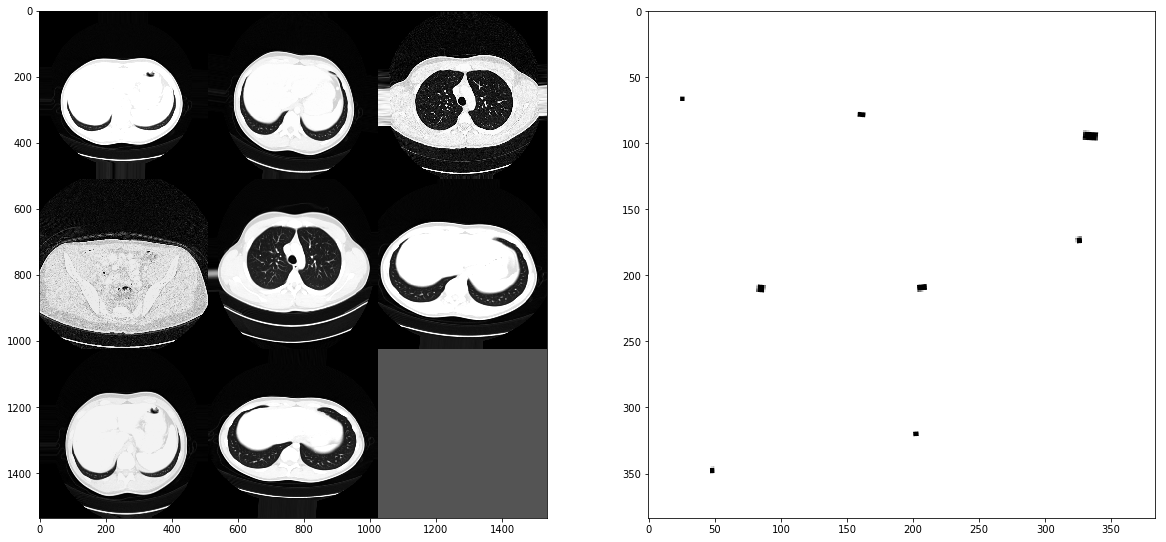

In [18]:
cur_gen = train_gen(8)
t_x, t_y = next(cur_gen)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
ax1.imshow(montage(t_x[:, :, :, 0]), cmap='gray')
ax2.imshow(montage(t_y[:, :, :, 0]), cmap='gray_r')

In [19]:
batch_size = 16
loss_history = [seg_model.fit_generator(train_gen(batch_size), 
                                        steps_per_epoch=train_x.shape[0]//batch_size, 
                                        epochs=40,
                                        validation_data=(test_x, test_y),
                                        callbacks=callbacks_list,
                                        workers=1)]

Epoch 1/40
59/59 [==============================] - 64s 1s/step - loss: -0.0167 - dice_coef: 0.0167 - binary_accuracy: 0.5889 - true_positive_rate: 0.9436 - val_loss: -0.0239 - val_dice_coef: 0.0239 - val_binary_accuracy: 0.6087 - val_true_positive_rate: 0.9318

Epoch 00001: val_dice_coef improved from -inf to 0.02386, saving model to seg_model_weights.best.hdf5
Epoch 2/40
59/59 [==============================] - 54s 920ms/step - loss: -0.0192 - dice_coef: 0.0192 - binary_accuracy: 0.6610 - true_positive_rate: 0.9514 - val_loss: -0.0267 - val_dice_coef: 0.0267 - val_binary_accuracy: 0.6312 - val_true_positive_rate: 0.9154

Epoch 00002: val_dice_coef improved from 0.02386 to 0.02665, saving model to seg_model_weights.best.hdf5
Epoch 3/40
59/59 [==============================] - 53s 902ms/step - loss: -0.0208 - dice_coef: 0.0208 - binary_accuracy: 0.6653 - true_positive_rate: 0.9585 - val_loss: -0.0280 - val_dice_coef: 0.0280 - val_binary_accuracy: 0.6510 - val_true_positive_rate: 0.9072

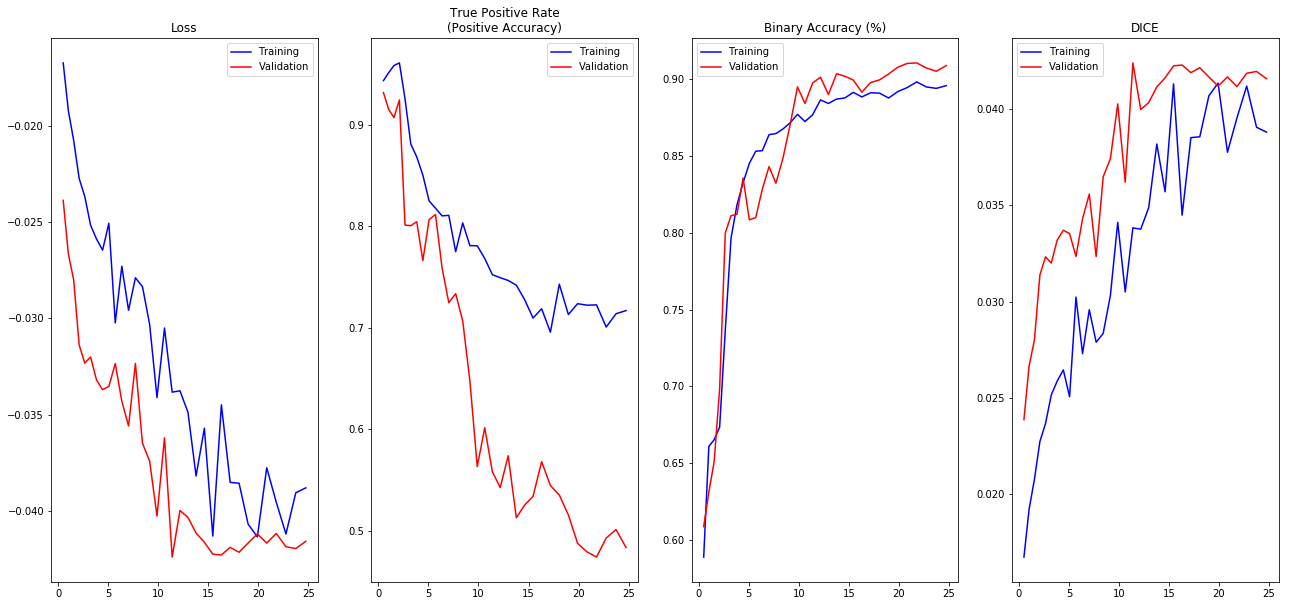

In [20]:
def show_loss(loss_history):
    epich = np.cumsum(np.concatenate(
        [np.linspace(0.5, 1, len(mh.epoch)) for mh in loss_history]))
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(22, 10))
    _ = ax1.plot(epich,
                 np.concatenate([mh.history['loss'] for mh in loss_history]),
                 'b-',
                 epich, np.concatenate(
            [mh.history['val_loss'] for mh in loss_history]), 'r-')
    ax1.legend(['Training', 'Validation'])
    ax1.set_title('Loss')

    _ = ax2.plot(epich, np.concatenate(
        [mh.history['true_positive_rate'] for mh in loss_history]), 'b-',
                     epich, np.concatenate(
            [mh.history['val_true_positive_rate'] for mh in loss_history]),
                     'r-')
    ax2.legend(['Training', 'Validation'])
    ax2.set_title('True Positive Rate\n(Positive Accuracy)')
    
    _ = ax3.plot(epich, np.concatenate(
        [mh.history['binary_accuracy'] for mh in loss_history]), 'b-',
                     epich, np.concatenate(
            [mh.history['val_binary_accuracy'] for mh in loss_history]),
                     'r-')
    ax3.legend(['Training', 'Validation'])
    ax3.set_title('Binary Accuracy (%)')
    
    _ = ax4.plot(epich, np.concatenate(
        [mh.history['dice_coef'] for mh in loss_history]), 'b-',
                     epich, np.concatenate(
            [mh.history['val_dice_coef'] for mh in loss_history]),
                     'r-')
    ax4.legend(['Training', 'Validation'])
    ax4.set_title('DICE')

show_loss(loss_history)


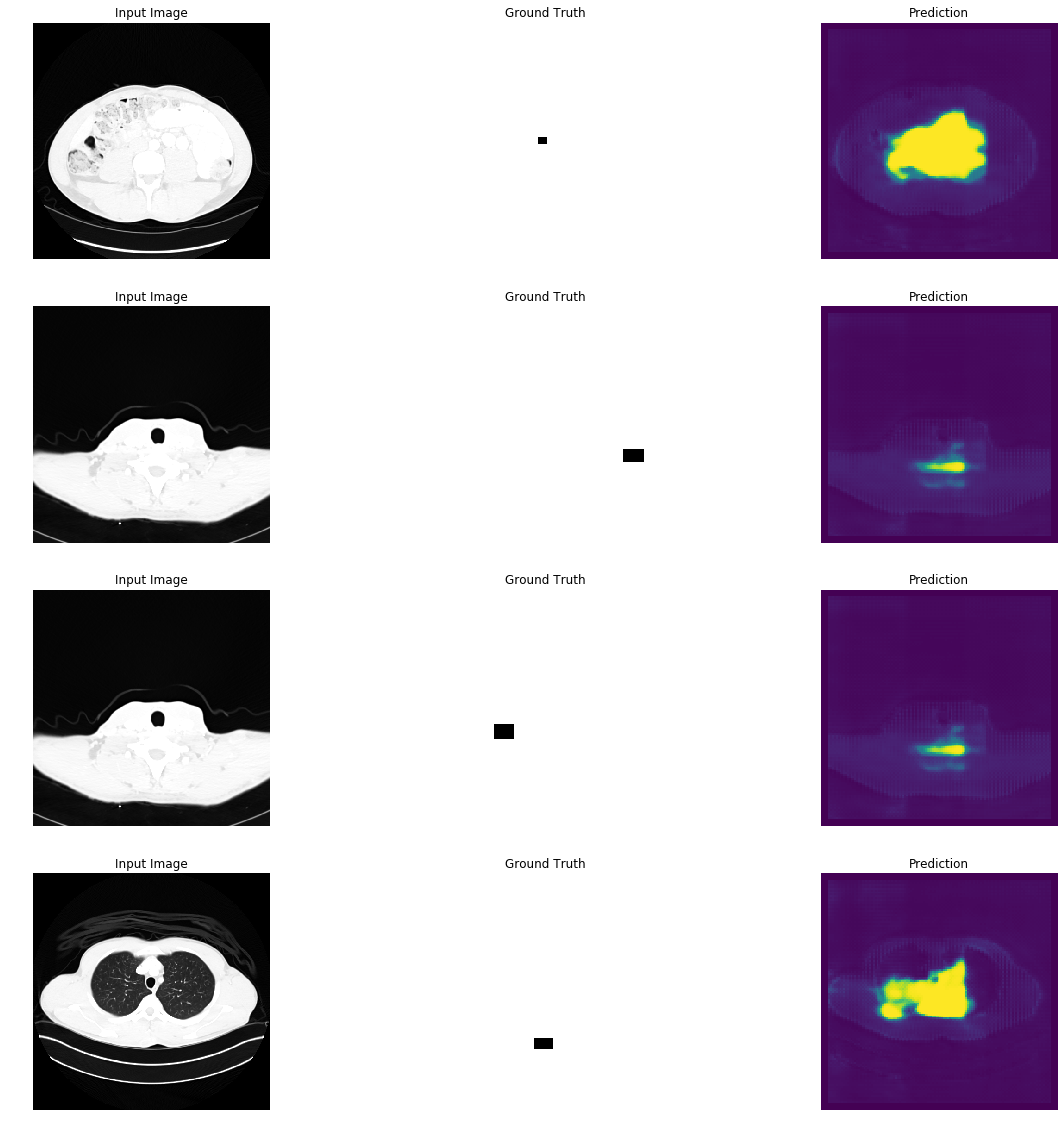

In [21]:
fig, m_axs = plt.subplots(4,3, figsize = (20, 20))
[c_ax.axis('off') for c_ax in m_axs.flatten()]
for idx, (ax1, ax2, ax3) in enumerate(m_axs):
    ix = test_x[idx:idx+1]
    iy = test_y[idx:idx+idx+1]
    p_image = seg_model.predict(ix)
    ax1.imshow(ix[0,:,:,0], cmap = 'gray')
    ax1.set_title('Input Image')
    ax2.imshow(iy[0,:,:,0], vmin = 0, vmax = 1, cmap = 'bone_r' )
    ax2.set_title('Ground Truth')
    ax3.imshow(p_image[0,:,:,0], vmin = 0, vmax = 1, cmap = 'viridis' )
    ax3.set_title('Prediction')

In [0]:
seg_model.load_weights(weight_path)
seg_model.save('seg_model.h5')

In [0]:
from keras.models import model_from_json
from keras.models import load_model

In [0]:
model_json = seg_model.to_json()

In [0]:
with open("model_num.json", "w") as json_file:
    json_file.write(model_json)

In [0]:
seg_model.save_weights("model_num.h5")

In [0]:
cur_gen = train_gen(1)
t_x, t_y = next(cur_gen)

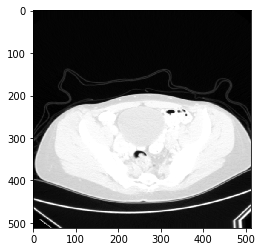

In [90]:
plt.imshow(montage(t_x[:, :, :, 0]),cmap="gray")

In [1]:
p_image = seg_model.predict(t_x)
plt.imshow(p_image[0,:,:,0], vmin = 0, vmax = 1, cmap = 'viridis' )

NameError: ignored

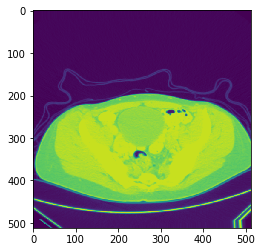

In [115]:
plt.imshow(t_x[0,:,:,0], vmin = 0, vmax = 1, cmap = 'viridis' )

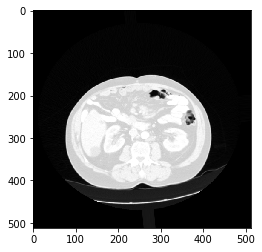

In [23]:
cur_gen = train_gen(1)
t_x, t_y = next(cur_gen)
plt.imshow(montage(t_x[:, :, :, 0]),cmap="gray")
a = seg_model.predict(t_x)


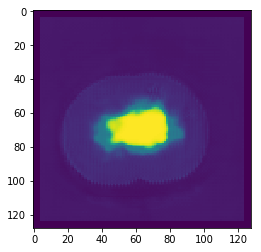

In [24]:
plt.imshow(a[0,:,:,0], vmin = 0, vmax = 1, cmap = 'viridis' )
